In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import os

In [4]:
data = pd.read_csv("/content/drive/MyDrive/archive/all-data.csv", encoding="latin1", on_bad_lines="skip")
data = data.dropna()
data = data.rename(columns={data.columns[0]: "Sentiment", data.columns[1]: "Text"})

le = LabelEncoder()
data['label'] = le.fit_transform(data['Sentiment'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Text'].tolist(),
    data['label'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=data['label']
)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
max_len = 128

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len=max_len)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_len=max_len)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [6]:
model = BertForSequenceClassification.from_pretrained(
    "google-bert/bert-base-cased",
    num_labels=len(le.classes_)
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 10
best_acc = 0.0
save_dir = "/content/drive/MyDrive/my_finbertbv2"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch {epoch+1} validation accuracy: {acc:.4f}, F1-score: {f1:.4f}")

    if acc > best_acc:
        best_acc = acc
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        print(f"New best model saved with accuracy: {best_acc:.4f}")

Epoch 1: 100%|██████████| 545/545 [01:48<00:00,  5.04it/s, loss=0.000258]


Epoch 1 validation accuracy: 0.8639, F1-score: 0.8631
New best model saved with accuracy: 0.8639


Epoch 2: 100%|██████████| 545/545 [01:44<00:00,  5.20it/s, loss=0.000513]


Epoch 2 validation accuracy: 0.8557, F1-score: 0.8554


Epoch 3: 100%|██████████| 545/545 [01:44<00:00,  5.19it/s, loss=0.000147]


Epoch 3 validation accuracy: 0.8577, F1-score: 0.8573


Epoch 4: 100%|██████████| 545/545 [01:44<00:00,  5.19it/s, loss=0.000769]


Epoch 4 validation accuracy: 0.8515, F1-score: 0.8519


Epoch 5: 100%|██████████| 545/545 [01:44<00:00,  5.19it/s, loss=0.000597]


Epoch 5 validation accuracy: 0.8330, F1-score: 0.8328


Epoch 6: 100%|██████████| 545/545 [01:44<00:00,  5.20it/s, loss=0.00113]


Epoch 6 validation accuracy: 0.8309, F1-score: 0.8323


Epoch 7: 100%|██████████| 545/545 [01:44<00:00,  5.19it/s, loss=0.000157]


Epoch 7 validation accuracy: 0.8495, F1-score: 0.8497


Epoch 8: 100%|██████████| 545/545 [01:44<00:00,  5.20it/s, loss=0.000212]


Epoch 8 validation accuracy: 0.8495, F1-score: 0.8487


Epoch 9: 100%|██████████| 545/545 [01:44<00:00,  5.20it/s, loss=0.000748]


Epoch 9 validation accuracy: 0.8330, F1-score: 0.8310


Epoch 10: 100%|██████████| 545/545 [01:44<00:00,  5.19it/s, loss=0.00234]


Epoch 10 validation accuracy: 0.8392, F1-score: 0.8379



===== FINAL EVALUATION =====
Accuracy: 0.8639
Weighted F1: 0.8631

Classification Report:
              precision    recall  f1-score     support
negative       0.857143  0.885246  0.870968   61.000000
neutral        0.887755  0.906250  0.896907  288.000000
positive       0.812500  0.764706  0.787879  136.000000
accuracy       0.863918  0.863918  0.863918    0.863918
macro avg      0.852466  0.852067  0.851918  485.000000
weighted avg   0.862802  0.863918  0.863072  485.000000

Confusion Matrix:
[[ 54   5   2]
 [  5 261  22]
 [  4  28 104]]


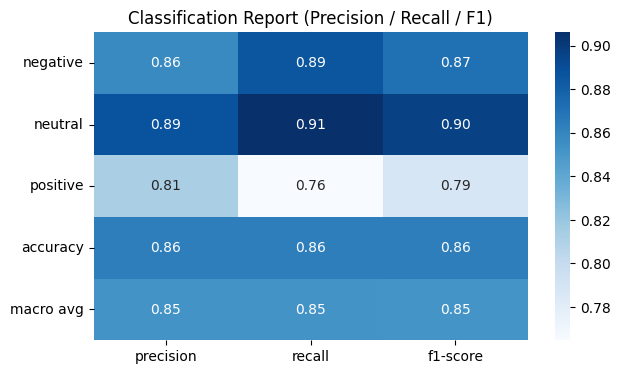

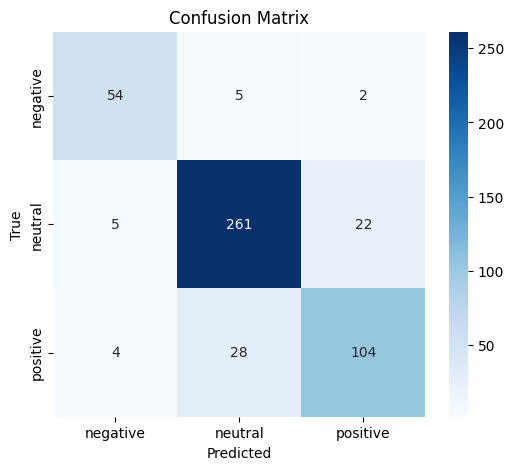

/tmp/ipython-input-997749017.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=f1_per_class, palette="Blues_d")


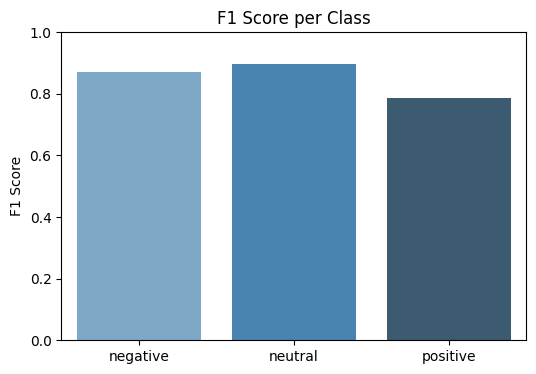

/tmp/ipython-input-997749017.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=support, palette="Greens_d")


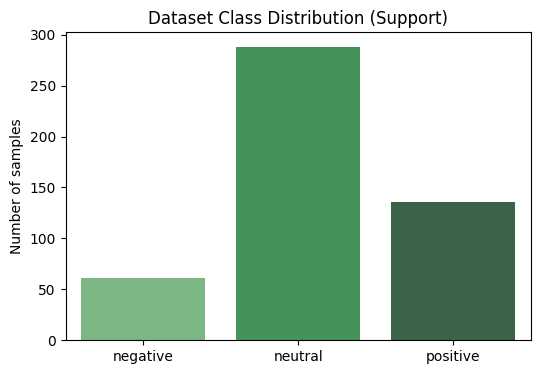

In [12]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
import pandas as pd
import numpy as np
from transformers import BertForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "/content/drive/MyDrive/my_finbertbv2"
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model.to(device)
model.eval()

all_preds = []
all_labels = val_labels

with torch.no_grad():
    for text in val_texts:
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1).cpu().item()
        all_preds.append(pred)

class_names = le.classes_

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")

print("\n===== FINAL EVALUATION =====")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}")

print("\nClassification Report:")
report_dict = classification_report(
    all_labels, all_preds, target_names=class_names, output_dict=True
)
report = pd.DataFrame(report_dict).transpose()
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(7,4))
sns.heatmap(report.iloc[:-1, :3], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report (Precision / Recall / F1)")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

f1_per_class = report.loc[class_names, "f1-score"]
plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=f1_per_class, palette="Blues_d")
plt.title("F1 Score per Class")
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.show()

support = report.loc[class_names, "support"]
plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=support, palette="Greens_d")
plt.title("Dataset Class Distribution (Support)")
plt.ylabel("Number of samples")
plt.show()
